In [21]:
# import torch
# import keras
# import torch.nn as nn
# from PIL import Image
# import torch.optim as optim
# from tensorflow.keras import layers, models, callbacks, regularizers
# from tensorflow.keras import layers, models
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras import layers, models, callbacks
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from tensorflow.keras import layers, models
# from tensorflow.keras.applications import VGG19, DenseNet121
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras import layers, models, callbacks
# from scipy.stats import mode


In [22]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

avoid OOM errors by setting GPU Memory Consumption Growth

In [23]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### Define base directories

In [24]:
base_dir = 'FracAtlas'
image_dir = os.path.join(base_dir, 'images')  # Path to 'images' folder
csv_dir = os.path.join(base_dir, 'Utilities', 'Fracture Split')  # Path to CSV folder


In [25]:
data = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    image_size=(224, 224), 
    batch_size=32,
    label_mode='int', 
)


Found 4024 files belonging to 2 classes.


In [26]:
data_iterator = data.as_numpy_iterator()
class_names = data.class_names
batch = data_iterator.next()

Display the first few images with their class names

In [27]:
for idx, img in enumerate(batch[0][:4]):
    label_index = batch[1][idx]  
    label_name = class_names[label_index]
    print(f"Image {idx+1}: Class label index = {label_index}, Class name = {label_name}")

Image 1: Class label index = 0, Class name = A_Non_fractured
Image 2: Class label index = 1, Class name = B_Fractured
Image 3: Class label index = 0, Class name = A_Non_fractured
Image 4: Class label index = 0, Class name = A_Non_fractured


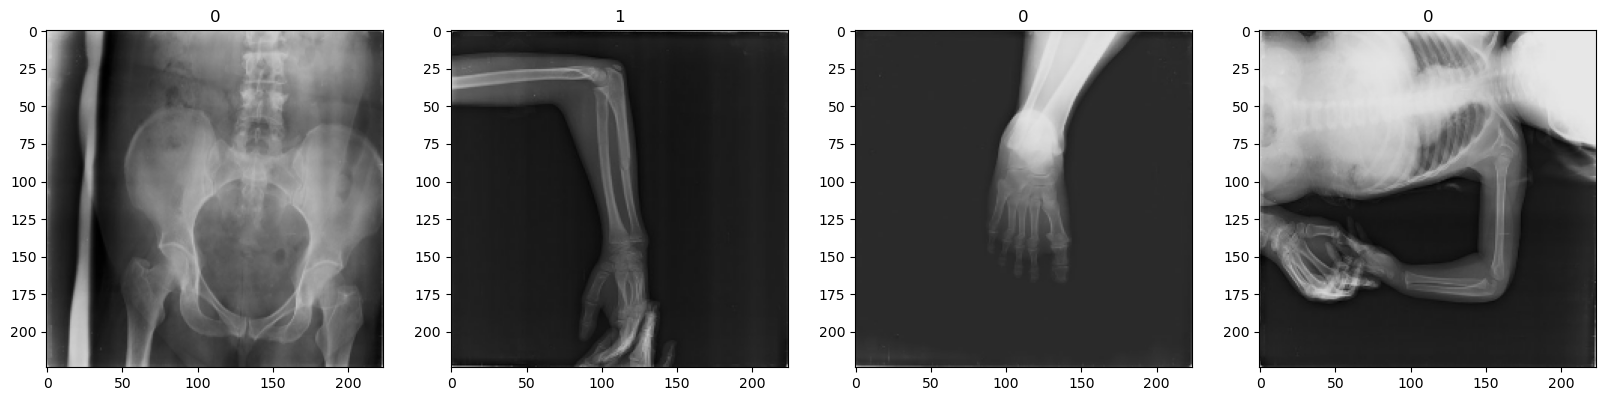

In [28]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### PreProcess Data

#### Scale Data

In [29]:
data = data.map(lambda x,y:(x/255,y))

In [30]:
# check
data.as_numpy_iterator().next()[0].min()

0.0

In [31]:
# check
data.as_numpy_iterator().next()[0].max()

1.0

#### Delete corrupt images

In [32]:
def find_and_delete_corrupt_images(directory):
    """
    Scans a directory recursively for corrupt images and deletes them.

    Args:
        directory (str): The path to the directory where images are stored.

    This function walks through all the subdirectories and files in the given
    directory. For each file, it attempts to decode the image using TensorFlow's
    `tf.io.decode_image` function. If the image is corrupt and cannot be decoded,
    an exception is raised, the image is deleted, and a count of deleted images is 
    maintained. Finally, the total number of deleted corrupt images is printed.

    Returns:
        None
    """
    corrupt_count = 0  # Initialize a counter for the corrupt images
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            try:
                img = tf.io.decode_image(tf.io.read_file(filepath))
            except tf.errors.InvalidArgumentError:
                # If an error occurs, it means the image is corrupt
                print(f"Corrupt image found and deleted: {filepath}")
                os.remove(filepath)  
                corrupt_count += 1 
    print(f"Total number of corrupt images deleted: {corrupt_count}")
    

In [33]:
find_and_delete_corrupt_images(image_dir)

Total number of corrupt images deleted: 0


#### Resize

In [34]:
target_size = (224, 224)
data = data.map(lambda x, y: (tf.image.resize(x, target_size), y))

In [35]:
# checking the shape of a batch
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print("Batch image shape:", batch[0][0].shape)  

Batch image shape: (224, 224, 3)


### Split data into Train (70%), Validation (20%), and Test (10%) sets

In [36]:
len(data)

126

In [37]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) +1
test_size = int(len(data)*.1) +1

In [38]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### Extract test data from dataset for evaluation and prediction

In [39]:
test_images = []
test_labels = []

for image_batch, label_batch in data.take(1):  
    test_images.append(image_batch)
    test_labels.append(label_batch)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

### CNN Model

In [40]:
# CNN Model with adjusted input shape and global average pooling
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Use Global Average Pooling to adapt the output size
    tf.keras.layers.GlobalAveragePooling2D(),
    
    # Dense layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax') 
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = cnn_model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 750ms/step - accuracy: 0.7778 - loss: 0.5360 - val_accuracy: 0.8522 - val_loss: 0.4238
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 805ms/step - accuracy: 0.8134 - loss: 0.4821 - val_accuracy: 0.8594 - val_loss: 0.3810
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 71s 796ms/step - accuracy: 0.8127 - loss: 0.4722 - val_accuracy: 0.8438 - val_loss: 0.4126
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 891ms/step - accuracy: 0.8092 - loss: 0.4677 - val_accuracy: 0.8281 - val_loss: 0.4110
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 851ms/step - accuracy: 0.8087 - loss: 0.4592 - val_accuracy: 0.8462 - val_loss: 0.4016
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 882ms/step - accuracy: 0.8120 - loss: 0.4653 - val_accuracy: 0.8450 - val_loss: 0.4107
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 893ms/step - accuracy: 0.8086 - loss: 0.4804 - val_accuracy: 0.8401 - val_loss: 0.4159
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 915ms/step - accuracy: 0.8197 - loss: 0.4437 - val_accu

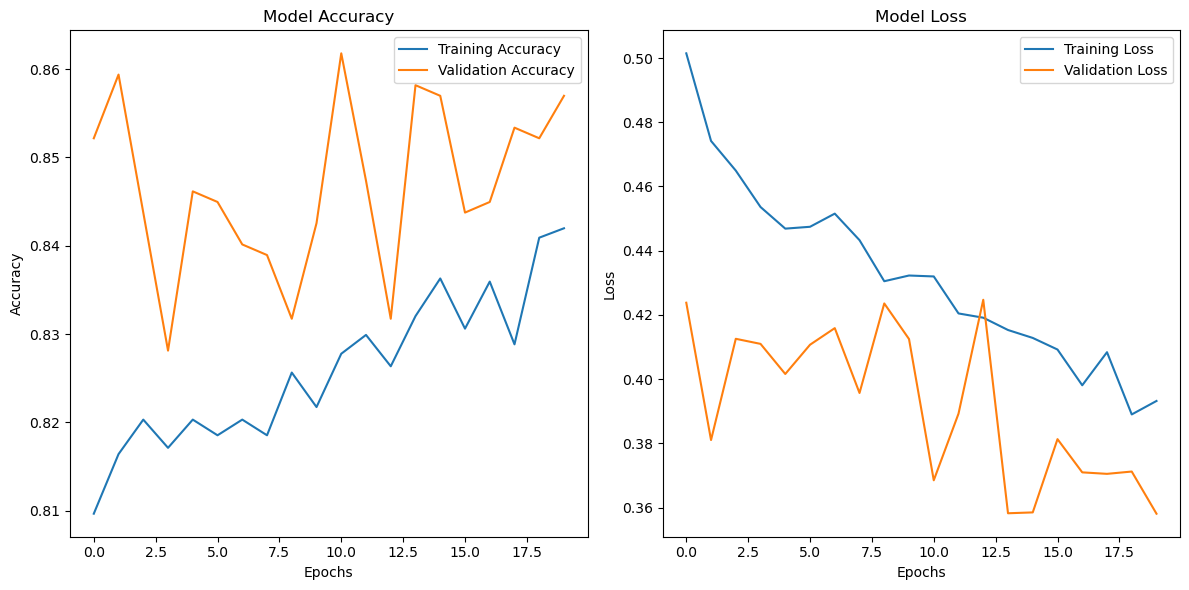

In [41]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


#### CNN evaluation

In [42]:
y_pred = cnn_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [43]:
print(f"Accuracy score: {accuracy_score(test_labels, y_pred_classes)}")

Accuracy score: 0.8125


In [44]:
print("Classification Report:\n", classification_report(test_labels, y_pred_classes, target_names=class_names))

Classification Report:
                  precision    recall  f1-score   support

A_Non_fractured       0.84      0.96      0.90        27
    B_Fractured       0.00      0.00      0.00         5

       accuracy                           0.81        32
      macro avg       0.42      0.48      0.45        32
   weighted avg       0.71      0.81      0.76        32



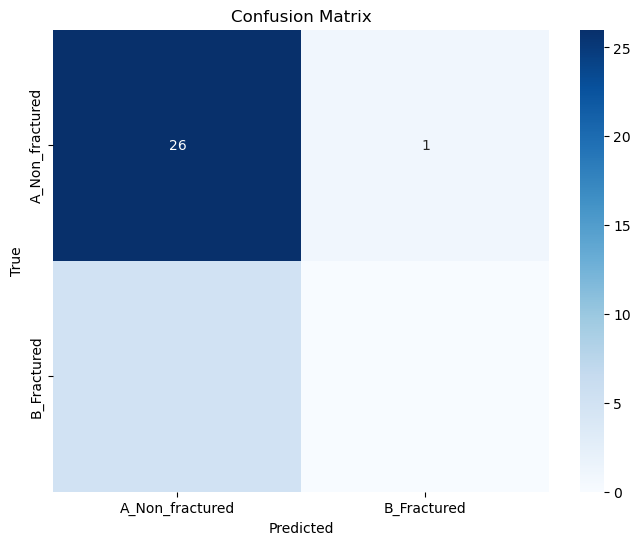

In [45]:
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### VGG19 Model

In [46]:
def create_vgg19_model(num_classes):
    """
    Creates a custom VGG19-based model for image classification with transfer learning.

    Args:
        num_classes (int): The number of classes for classification (i.e., the size of the output layer).

    Returns:
        tensorflow.keras.Model: A compiled Keras model with the VGG19 base and a custom classification head.
        
    This function uses the VGG19 model as the base (pre-trained on ImageNet) and freezes its layers
    for transfer learning. It then adds a custom classification head consisting of:
        - Global Average Pooling (to reduce the spatial dimensions of the feature maps),
        - Fully connected layers with ReLU activations (256 and 128 units),
        - Dropout layers to prevent overfitting (60% dropout rate after the first dense layer, and 50% after the second),
        - A final output layer with a softmax activation to output probabilities for each class.
    
    The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss function.
    """
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    # Custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Replaces Flatten with Global Average Pooling
    x = layers.Dense(256, activation='relu')(x)  # Fully connected layer with 256 units
    x = layers.Dropout(0.6)(x)   # Dropout layer with 60% dropout rate
    x = layers.Dense(128, activation='relu')(x)  # Another fully connected layer with 128 units
    x = layers.Dropout(0.5)(x)   # Dropout layer with 50% dropout rate
    output = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

    # Combine the base model with the classification head
    final_model = models.Model(inputs=base_model.input, outputs=output)

    # Compile the model
    final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return final_model


In [47]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg19_model = create_vgg19_model(2)
vgg19_model.fit(train, epochs=1, validation_data=val, callbacks=[early_stopping])

88/88 ━━━━━━━━━━━━━━━━━━━━ 706s 8s/step - accuracy: 0.7804 - loss: 0.5779 - val_accuracy: 0.8498 - val_loss: 0.4232


#### VGG19 evaluation

In [48]:
y_pred = vgg19_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [49]:
print(f"Accuracy score: {accuracy_score(test_labels, y_pred_classes)}")

Accuracy score: 0.84375


In [50]:
print("Classification Report:\n", classification_report(test_labels, y_pred_classes, target_names=class_names))


Classification Report:
                  precision    recall  f1-score   support

A_Non_fractured       0.84      1.00      0.92        27
    B_Fractured       0.00      0.00      0.00         5

       accuracy                           0.84        32
      macro avg       0.42      0.50      0.46        32
   weighted avg       0.71      0.84      0.77        32



c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


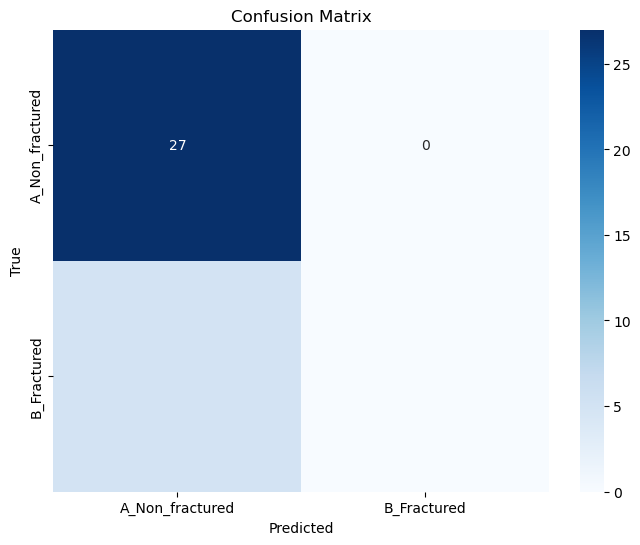

In [51]:
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Densenet Model

In [52]:
def create_densenet_model(num_classes):
    """
    Creates a custom DenseNet121-based model for image classification with transfer learning.

    Args:
        num_classes (int): The number of classes for classification (i.e., the size of the output layer).

    Returns:
        tensorflow.keras.Model: A compiled Keras model with the DenseNet121 base and a custom classification head.
        
    This function uses the DenseNet121 model as the base (pre-trained on ImageNet) and freezes its layers
    for transfer learning. It then adds a custom classification head consisting of:
        - Global Average Pooling (to reduce the spatial dimensions of the feature maps),
        - Fully connected layers with ReLU activations (256 and 128 units) and L2 regularization,
        - Dropout layers to prevent overfitting (50% dropout rate after each dense layer),
        - A final output layer with a softmax activation to output probabilities for each class.
    
    The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss function.
    """
    base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Replaces Flatten with Global Average Pooling
    x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)  # Dense layer with L2 regularization
    x = layers.Dropout(0.5)(x)  # Dropout layer with 50% dropout rate
    x = layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)  # Another Dense layer
    x = layers.Dropout(0.5)(x)  # Dropout layer with 50% dropout rate
    output = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

    # Combine the base model with the custom classification head
    final_model = models.Model(inputs=base_model.input, outputs=output)

    final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return final_model

In [53]:
# Set up early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create and train DenseNet model
densenet_model = create_densenet_model(2)
densenet_model.fit(train, epochs=1, validation_data=val, callbacks=[early_stopping])

88/88 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.7617 - loss: 4.4919 - val_accuracy: 0.8558 - val_loss: 1.7683


#### DenseNet evaluation

In [54]:
y_pred = densenet_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [55]:
print(f"Accuracy score: {accuracy_score(test_labels, y_pred_classes)}")

Accuracy score: 0.84375


In [56]:
print("Classification Report:\n", classification_report(test_labels, y_pred_classes, target_names=class_names))

Classification Report:
                  precision    recall  f1-score   support

A_Non_fractured       0.84      1.00      0.92        27
    B_Fractured       0.00      0.00      0.00         5

       accuracy                           0.84        32
      macro avg       0.42      0.50      0.46        32
   weighted avg       0.71      0.84      0.77        32



c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


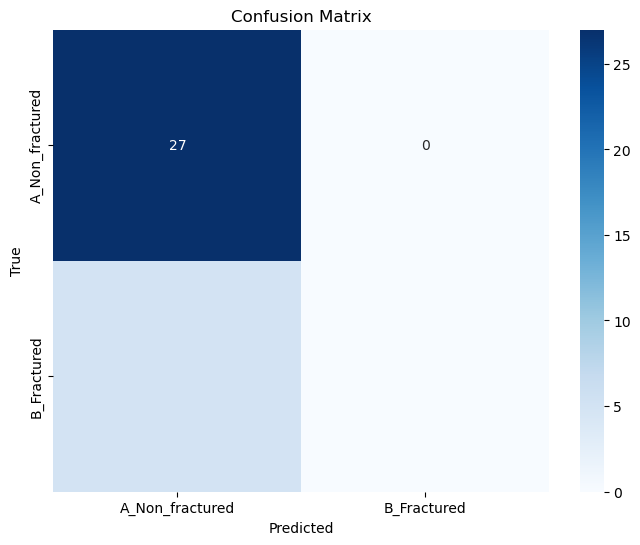

In [57]:
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Save the models

In [58]:
vgg19_model.save("vgg19_model.h5")
densenet_model.save("densenet_model.h5")
cnn_model.save("cnn_model.h5")

### Ensemble Learning (Hard Voting)

In [59]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Loads and preprocesses an image from the given file path.

    Args:
        image_path (str): Path to the image file to be loaded.
        target_size (tuple): Desired target size for the image (height, width). Default is (224, 224).

    Returns:
        tf.Tensor: A tensor representing the preprocessed image with shape (1, height, width, channels).
                   The image is resized, normalized (scaled to [0, 1]), and has an added batch dimension.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)
    return image

In [60]:
def hard_voting_ensemble(image, cnn_model, vgg19_model, densenet_model):
    """
    Performs a hard voting ensemble on the predictions from three models (CNN, VGG19, and DenseNet) to make a final prediction.

    Args:
        image (np.ndarray): A preprocessed image with shape (1, 224, 224, 3). The image to be classified.
        cnn_model (tf.keras.Model): The CNN model used for prediction.
        vgg19_model (tf.keras.Model): The VGG19 model used for prediction.
        densenet_model (tf.keras.Model): The DenseNet model used for prediction.

    Returns:
        int: The final predicted class label based on the majority vote from the three models.
    
    Raises:
        AssertionError: If the input image shape is not (1, 224, 224, 3), which is expected for model input.
    """
    # Ensure image is preprocessed and has the correct shape
    assert image.shape == (1, 224, 224, 3), f"Image shape is incorrect: {image.shape}"
    
    cnn_pred = np.argmax(cnn_model.predict(image), axis=1)[0]
    vgg19_pred = np.argmax(vgg19_model.predict(image), axis=1)[0]
    densenet_pred = np.argmax(densenet_model.predict(image), axis=1)[0]
    
    predictions = [cnn_pred, vgg19_pred, densenet_pred]
    final_prediction = max(set(predictions), key=predictions.count)  # Mode of predictions

    return final_prediction


#### Ensemble learning evaluation

In [61]:
def preprocess_image(image, target_size=(224, 224)):
    """
    Preprocesses an image to make it compatible with the models for prediction.

    Args:
        image (tf.Tensor): The image tensor to be preprocessed.
        target_size (tuple, optional): The target size for resizing the image (default is (224, 224)).

    Returns:
        tf.Tensor: The preprocessed image ready for model prediction.
    
    The function performs the following steps:
    1. Resizes the image to the specified target size.
    2. Normalizes the image pixel values by dividing by 255 (scaling to [0, 1]).
    3. Expands the dimensions of the image to match the input shape required by the model.
    """
    image = tf.image.resize(image, target_size)  
    image = image / 255.0  
    image = tf.expand_dims(image, axis=0)  
    return image


In [62]:
def evaluate_hard_voting_ensemble(test_data, cnn_model, vgg19_model, densenet_model):
    """
    Evaluates the performance of a hard voting ensemble of models on a test dataset.

    Args:
        test_data (tf.data.Dataset): A TensorFlow dataset containing test images and labels.
        cnn_model (tf.keras.Model): The CNN model used for predictions in the ensemble.
        vgg19_model (tf.keras.Model): The VGG19 model used for predictions in the ensemble.
        densenet_model (tf.keras.Model): The DenseNet model used for predictions in the ensemble.

    Returns:
        float: The accuracy of the hard voting ensemble on the test dataset.
    """
    correct_predictions = 0
    total_samples = 0
    
    # Loop through the test dataset
    for images, labels in test_data:
        for i in range(len(images)):
            image = images[i]
            true_label = labels[i].numpy()            
            preprocessed_image = preprocess_image(image)            
            predicted_label = hard_voting_ensemble(preprocessed_image, cnn_model, vgg19_model, densenet_model)
            
            # Check if the ensemble prediction matches the true label
            if predicted_label == true_label:
                correct_predictions += 1
            total_samples += 1
    
    accuracy = correct_predictions / total_samples
    return accuracy


In [63]:
ensemble_accuracy = evaluate_hard_voting_ensemble(test, cnn_model, vgg19_model, densenet_model)
print(f"Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/ste

### Using hard voting ensemble for image classification prediction

In [64]:
image_path = 'IMG0000143.jpg'
image = load_and_preprocess_image(image_path)

predicted_class = hard_voting_ensemble(image, cnn_model, vgg19_model, densenet_model)
print(f"Ensemble Prediction: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Ensemble Prediction: 0
